# Capstone Project 1 - Final Report

## Introduction

In 2008, a Portuguese bank conducted a 3-year telemarketing campaign to over 45,000 existing customers, with the aim of increasing term deposit customers. The campaign data and results were then analysed in a research paper titled “Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology”. The paper’s researchers developed a model, using customer demographics and other factors, to predict the likelihood of a customer opening a term deposit. Based on the model, the authors then shared insights and recommended actions for the better performance and Return Of Investment (ROI) of future direct marketing campaigns.

The researchers made a portion of the marketing dataset available to the public. It contains the information of 45,211 customers who were contacted, with some redacted fields due to privacy concerns. For this project, I have utilised this data set  to create my own predictive models, I will also try to gain insights which will be able to help future marketing campaigns.

The original research paper can be found here:

https://pdfs.semanticscholar.org/a175/aeb08734fd669beaffd3d185a424a6f03b84.pdf


## Exploritory Data Analysis

We will start by importing the data and analysing the overall structure of the dataset.

In [4]:
import pandas as pd
import warnings
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
# Load the data into a pandas data frame
bank = pd.read_csv('bank_full.csv', delimiter=',')

To get a better idea of what the dataset looks like, we look at the head, description, and data types of the dataset.

In [6]:
print(bank.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  year  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may  2008       261         1     -1         0  unknown  no  
1  unknown    5   may  2008       151         1     -1         0  unknown  no  
2  unknown    5   may  2008        76         1     -1         0  unknown  no  
3  unknown    5   may  2008        92         1     -1         0  unknown  no  
4  unknown    5   may  2008       198         1     -1         0  unknown  no  


In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
year         45211 non-null int64
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(8), object(10)
memory usage: 6.2+ MB


In [5]:
bank.describe()

,age,balance,day,year,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,2008.444626,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,0.602364,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,2008.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,2008.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,2008.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,2009.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,2010.000000,4918.000000,63.000000,871.000000,275.000000


From this, we can see that our data frame has 45,211 rows and 18 columns. Each row contains the details related to one customer. Each column represents a feature or variable of the dataset. We have 17 independent variables and one dependent variable which is called 'y', which represents the outcome of the marketing campaign.

Note that the “year” variable was missing in the original dataset. Since the marketing campaign took place from 2008 to 2010, and the dataset is in date order, we can infer the year that final contact occured, and hence manually input the year variable for all contacts. 

We will now explore the important variables of our dataset.

#### Output variable - y

This is our binary output variable, which tells us whether the campaign resulted in a customer opening a term deposit. From the campaign outcome graph, we can see that the outcome is imbalanced. Of the 45,211 customers contacted, only 11.7% opened a term deposit. 

Modeling with an imbalanced dataset may be problematic. It is for this reason that when we approach the model creation we must be cautions with regards to what evaluation metric we use. The reason for this is that if we use a basic evaluation technique such as accuracy, even a naive classifier which assumes that every customer will decline to open a term deposit, will score an accuracy of 88.3%.

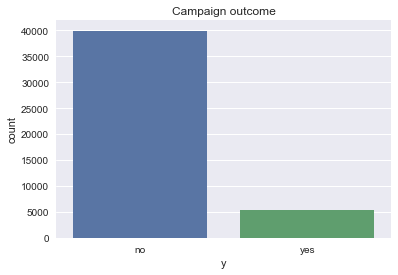

In [6]:
sns.countplot(x="y", data=bank).set_title('Campaign outcome')

In [7]:
# Proportion of yes/no

# we'll start off by counting the total number of people who did and didn't subscribe
ycount = bank['y'].value_counts()
# we need to count the number of total observations
rowcount = bank.shape[0]-1

print('Proportion yes: ' + '{0:2.3f}'.format((ycount[1]/rowcount)))
print('Proportion no: ' + '{0:2.3f}'.format((ycount[0]/rowcount)))

# We'll save the overall proportion of successes as the variable expected, this will help us with our chi squared tests
expected = ycount[1]/rowcount

Proportion yes: 0.117
Proportion no: 0.883


#### Age

This variable records the age of each customer at the point of contact. A histogram and boxplot is used to visualise the data distribution. The age distribution of the people who opened term deposit accounts, versus those who did not, is shown in the comparative graph. It appears that customers who said no are slightly older that those who said yes.

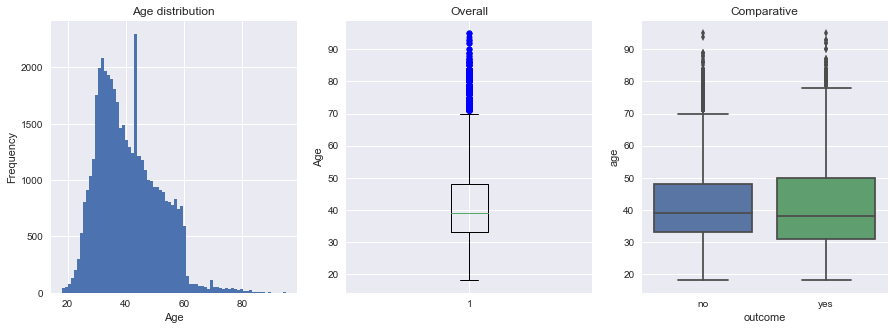

In [8]:
plt.subplot(1, 3, 1)
ageplt = bank.age.plot( kind='hist', bins = 74, figsize=(15,5))
plt.xlabel('Age')
plt.title('Age distribution')

plt.subplot(1, 3, 2)
agebox = plt.boxplot(bank.age, 0, 'b')
plt.ylabel('Age')
plt.title('Overall')


plt.subplot(1, 3, 3)
agebox2 = sns.boxplot(x="y", y="age", data=bank)
agebox2.set(xlabel='outcome')
plt.title('Comparative')

#### Job

It is interesting to analyse variations in the success rate between different occupational groups. While it is hardly surprising to see retirees subscribing to term deposits, other categories yield more surprises, such as the the success rate with blue-collar workers, students, and the unemployed. This is contrasted with the low success rate among managers, whom one would assume has the financial means to hold a diverse investment portfolio, including term deposits. However, it is difficult to deduce the reason for these disparities  from the dataset alone.

One issue with the dataset is that there is a group of customers whose jobs are unknown. The success rate amongst customers with unknown occupations is similar to the overall campaign success rate. Since these two success rates  are nearly identical, and since there are so few with unlisted occupations, these customers will be removed when the dataset is cleaned later on to allow for a more accurate predictive model.


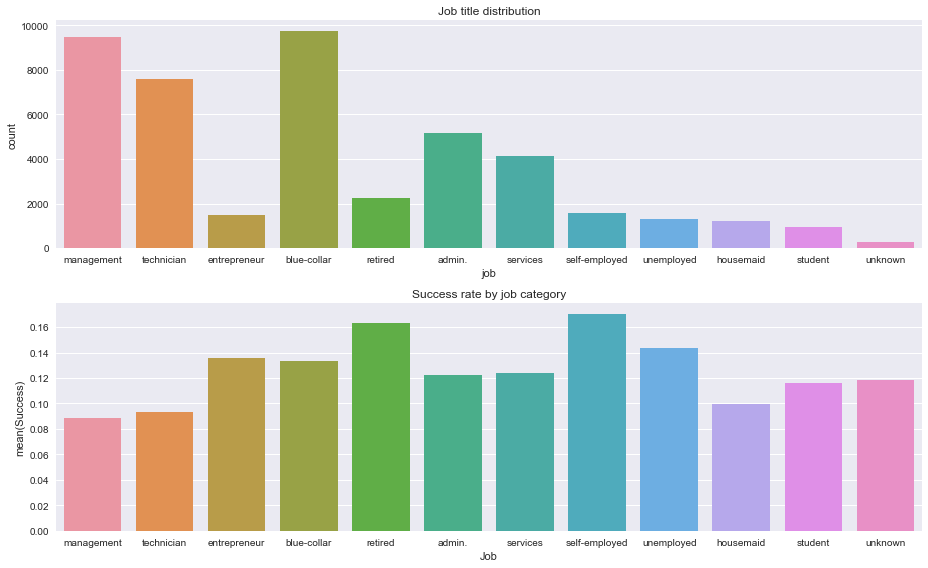

In [9]:
# We first graph the job titles and their respective totals
x = ['management', 'technician','entrepreneur','blue-collar','retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student', 'unknown']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="job", data=bank, order=x).set_title('Job title distribution')

# We then want to graph the which shows how successful the campaign was with each job category, to do this we first need to build a data frame which shows the proportion of success, grouped by job
jobsuccess = bank['job'].loc[bank['y']== 'yes'].value_counts()
jobcount = bank['job'].value_counts()
X = pd.DataFrame(columns=['Job','Success'])

Job=[]
Success=[]
for item in range(len(jobcount)):
    Job.append(jobcount.keys()[item])
    Success.append(jobsuccess[item]/jobcount[item])

Proportion = {'Job':Job, 'Success':Success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='Job', y='Success', data=X, order=x).set_title('Success rate by job category')
plt.tight_layout()

#### Month

It is interesting to see how dramatic the variation in success rate is between months, especially considering that the  campaign  spanned three years. May had the lowest success rate across the three years, yet most calls were made in May. The months with the least calls made, such December and March, had higher success rates.

The modeling section of the capstone project shows that the variation between months has a statistical significance, instead of being due to random noise. Thus, it can be inferred that the Portuguese bank’s campaign could have been more lucrative if they investigated the disparity in success rate between months. A possible reason for the disparity could be that the months relate to when the term deposits come to maturity, thus the high success rate is due to the bank contacting existing subscribers and asking them if they want to roll over the account for another term.

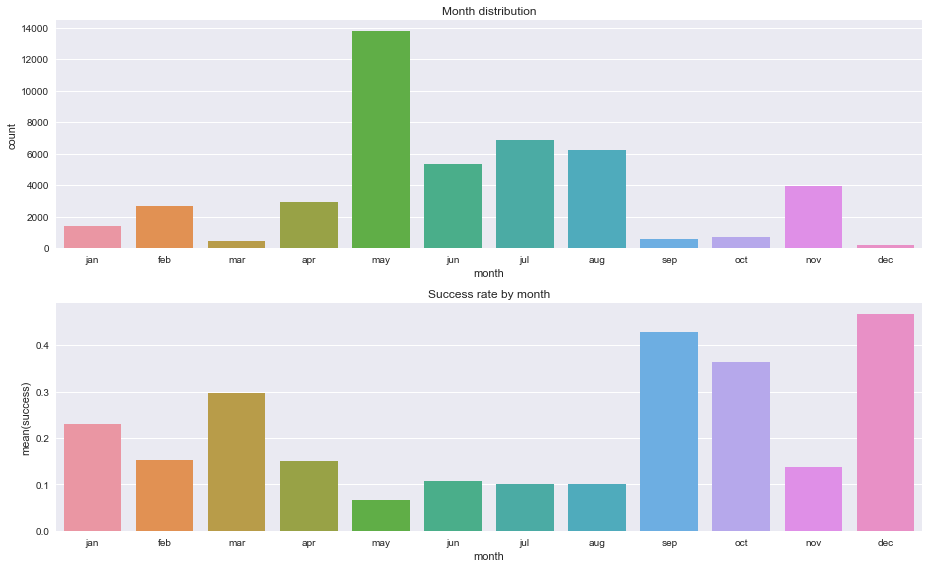

In [10]:
# Let's look at the success rate, categorised by month
# We first graph the Month and their respective totals
x = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="month", data=bank, order=x).set_title('Month distribution')

# We then want to graph the which shows how successful the campaign was by month, to do this we first need to build a data frame which shows the proportion of success, grouped by month
monthsuccess = bank['month'].loc[bank['y']== 'yes'].value_counts()
monthcount = bank['month'].value_counts()
X = pd.DataFrame(columns=['month','Success'])

month=[]
success=[]
for item in range(len(monthcount)):
    month.append(monthcount.keys()[item])
    success.append(monthsuccess[item]/monthcount[item])

Proportion = {'month':month, 'success':success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='success', data=X, order=x).set_title('Success rate by month')
plt.tight_layout()

#### Duration

The figures below show the distribution of the durations of the final phone call. The Duration distribution graph, shows a strong imbalance in the duration, with most phone calls being fairly short. Since the overall success rate is 11.7%, it can be inferred that unsuccessful calls tend to be shorter than successful ones.

The comparative graph confirms this guess. Successful calls tend to be much longer than the unsuccessful calls. This makes intuitive sense, since interested customers will spend more time with the marketer and ask questions about the product. Signing up for the product also takes additional time. This is in comparison to the uninterested customer, who is likely unwilling to spend time on the phone with the marketer.

However, this variable is problematic since the length of the final call is only known once the outcome of the call is known, i.e. whether or not the customer opened a term deposit account. This problem arose when the researchers confused causation with correlation, and instead of merely stating that the correlation between the two, they made the recommendation that telemarketers should try to stay on the line for as long as possible with customers to increase the probability of them opening a term deposit. 

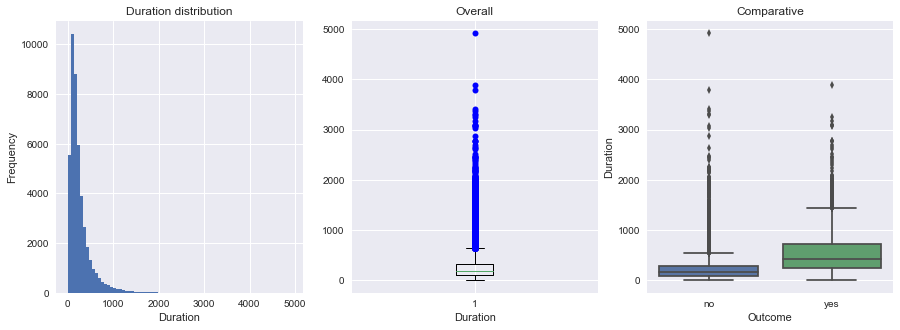

In [11]:
# Let's look at the duration of the final call
plt.subplot(1, 3, 1)
durationplt = bank.duration.plot( kind='hist', bins = 74, figsize=(15,5))
plt.xlabel('Duration')
plt.title('Duration distribution')

plt.subplot(1, 3, 2)
durationbox = plt.boxplot(bank.duration, 0, 'b')
plt.xlabel('Duration')
plt.title('Overall')

plt.subplot(1, 3, 3)
durationbox2 = sns.boxplot(x="y", y="duration", data=bank)
durationbox2.set(xlabel='Outcome')
durationbox2.set(ylabel='Duration')
plt.title('Comparative')

#### Balance

This is the account balance of the customer in Euros. We can see that on average, customers who subscribe to a term deposit have a larger account compared to the customers who do not. This is not surprising. However, the low account balance of both groups is surprising; even the group that subscribed had, on average, less than 1,000 Euros. It is important to note that this is not a measure of the total networth of the customers, as they likely have other assets.

There is a large spread of account balances, ranging from those with small negative balances to those with over 100,000 Euros. Despite these extremes being outliers, the balances are still reasonable, thus they are untouched when the dataset is cleaned 

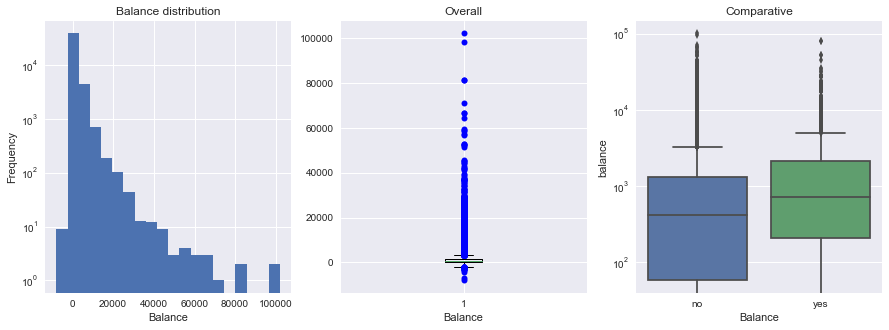

In [12]:
plt.subplot(1, 3, 1)
balanceplt = bank.balance.plot( kind='hist', bins = 20, figsize=(15,5))
plt.xlabel('Balance')
balanceplt.set_yscale('log')
plt.title('Balance distribution')

plt.subplot(1, 3, 2)
balancebox = plt.boxplot(bank.balance, 0, 'b')
plt.xlabel('Balance')
plt.title('Overall')

plt.subplot(1, 3, 3)
balancebox2 = sns.boxplot(x="y", y="balance", data=bank)
balancebox2.set(xlabel='Balance')
plt.yscale('log')
plt.title('Comparative')

#### Pdays

This variable records the number of days that passed after a customer was last contacted from a previous campaign. The comparative boxplot on the right shows that customers who were previously contacted are more likely to open an account.

It also shows that  there are many outliers in the dataset However, since the campaign was conducted over a three year period, a pdays value of just under 900 is plausible, thus these outliers are not removed  in the data cleaning.

Majority of customers in the dataset were not contacted in a previous campaign, and a placeholder of -1 days is used to signify that the customer was not previously contacted. Since there are too many customers who were not contacted, it is not feasible to remove them. The most sensible way of dealing with these missing values is to keep the placeholder of -1.

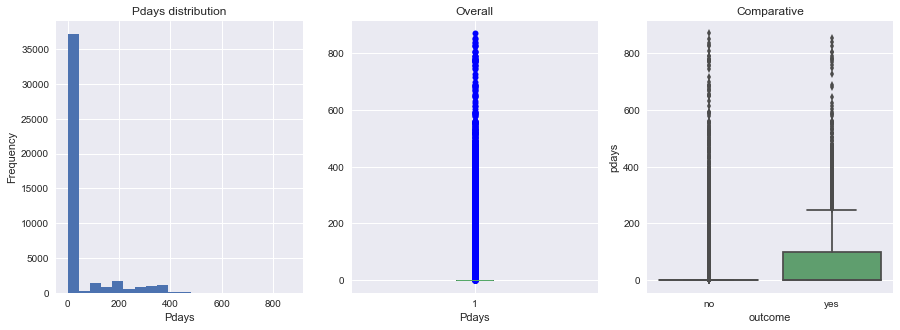

In [13]:
# Pdays - , note -1 means not previously contacted

plt.subplot(1, 3, 1)
pdaysplt = bank.pdays.plot( kind='hist', bins = 20, figsize=(15,5))
plt.xlabel('Pdays')
plt.title('Pdays distribution')

plt.subplot(1, 3, 2)
pdaysbox = plt.boxplot(bank.pdays, 0, 'b')
plt.xlabel('Pdays')
plt.title('Overall')

plt.subplot(1, 3, 3)
pdaysbox2 = sns.boxplot(x="y", y="pdays", data=bank)
pdaysbox2.set(xlabel='outcome')
plt.title('Comparative')

#### Education

The education variable records the highest level of education attained by each customer. Two interesting patterns can be observed. Firstly, the success rate by education level graph shows that as the level of education of the customer increases, so too does the likelihood that the customer will open a term deposit. Secondly, it shows that customers who did not provide their education level have the second highest success rate. Since the rate at which they open accounts is about 2% above the global mean of 11.7%, it is statistically significant. Thus, it is best to treat the unknown variable as a legitimate fourth category.

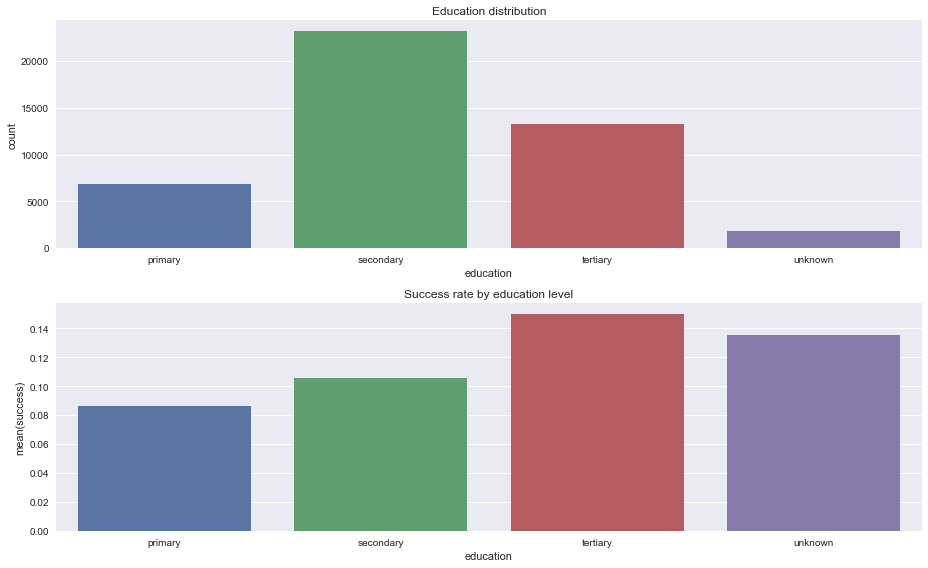

In [14]:
# We first graph the education level and their respective totals
x = ['primary','secondary' ,'tertiary' , 'unknown']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="education", data=bank, order=x).set_title('Education distribution')

# We then want to graph the which shows how successful the campaign was with each education level, to do this we first need to build a data frame which shows the proportion of success, grouped education level
educationsuccess = bank['education'].loc[bank['y']== 'yes'].value_counts()
educationcount = bank['education'].value_counts()
X = pd.DataFrame(columns=['education','Success'])

education=[]
success=[]
for item in range(len(educationcount)):
    education.append(educationcount.keys()[item])
    success.append(educationsuccess[item]/educationcount[item])

Proportion = {'education':education, 'success':success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='education', y='success', data=X, order=x).set_title('Success rate by education level')
plt.tight_layout()

## Data preparation

To clean the data set we will:

- Rows with unknown jobs were removed, as discussed above, since the success rate of the group is almost the same as the whole dataset, and since these were only 288 rows. 
- Categorical data is encoded using a label encoder. The month values were mapped using kept pair values, since the order of the labels matters.  A label encoder is used for the rest of the categorical variables.

In [7]:
# We drop the 288 rows where the job is unknown
bank = bank.drop(bank[bank.job=='unknown'].index)

In [8]:
# Map function to convert the months to numeric
bank['month'] =bank['month'].map({
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
    })

In [9]:
# We then initalise the label encoder and use it to encode the rest of our catgorical variables
lb_make = LabelEncoder()

categories = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
for col in categories: 
    bank[str(col)+"_code"] = lb_make.fit_transform(bank[col])    

Until now, data scientists modeling this dataset have used a feature numbering the day of the month (e.g. 13) and the month (e.g. June) separately. Looking at previous research, it appears that these features are statistically significant. However, the problem with the current approach is that it misses the bigger picture. The dataset represents a marketing campaign which was conducted over a three year period. Thus, it is naive to treat days and months as if they were homogenous, e.g. to say that the 5th of July 2008 is equivalent to 5th of July 2010. Social and economic factors  affect the consumers’ behaviour, and since these factors are constantly changing, it makes sense to add a date variable which combines the day of the month, the month, and the year e.g. 5 June 2009.

Another factor which had a large effect on the performance of the model was the addition of a feature which captured the difference between the Portuguese Consumer Price Index and the Portuguese three-month term deposit rate. The rationale behind this feature is that customers are rational, hence, rather than looking at the nominal rate (i.e. the term deposit rate), they are concerned with the real rate of return, which is the difference between the term deposit rate and the CPI.

The final three features included are the level of unemployment, CPI, and the change in the monthly unemployment rate between the current and previous month. These features lead to modest improvements in the model’s performance.
The data for these dates have been stored in a file called features. It was uploaded as a data frame and merged with the bank data frame.

In [10]:
# Create date feature using the format DDMMYYYY
bank['date'] = (bank['day']*1000000)+(bank['month']*10000)+bank['year']

# Create a 'features' column so that we have a common colum to merge our dataframes
bank['features'] = (bank['month']*10000)+bank['year']

In [11]:
# Load features into a data frame
features = pd.read_csv('features.csv', delimiter=',')

In [12]:
# Merge on the common variable 
bank2 = pd.merge(bank, features, on="features")

In [13]:
# Drop redundant columns and split into input and output variables
X = bank2.drop(['y_code', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y', 'month', 'day', 'year', 'features'],axis=1)
y = bank2['y_code']

## Model creation

Although some may treat this dataset as if it were a classification problem, we treat it as more of a predictive one. This does not imply the prediction of whether or not someone will open a term deposit account, but rather the modelling of how probable each customer is to open a term deposit account. 

The outcome in this problem is binomial, and we are attempting to construct a probability distribution for each category of outcome. As such, the area under the receiver operator curve (AUC) is the optimal choice as an evaluation metric since the closer the AUC to 1 is, the better the distributions are separated. This means that our model is more effective at differentiating those who will open an account and those who will not. 

Previous research on this dataset utilise the AUC as their evaluation metric, they were able to achieve an AUC score of 0.938. 


In [14]:
# We define a function which will allow us to time how long it takes to run our functions
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [15]:
# We then split the data into a training and testing set and train the decision tree 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Decision tree

In [16]:
tic()
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print('AUC: ' + str(roc_auc_score(y_test, predictions)))
toc()

AUC: 0.727099462238
Elapsed time is 0.2832777500152588 seconds.


The AUC score is certainly better than a random guess, which would give a score of 0.5. Perhaps using a collection of decision trees will be able to yield better performance.

#### XGBoost

XGBoost, which is short for extreme gradient boosting uses a collection of weak learners to build a predictive model. A good analogy to explain how this process works would be to imagine a collection of decision trees voting on how probable a customer is of opening a term deposit account. Although each decision tree may only be slightly better than a random guess, a whole collection of trees may do a great job or predicting the outcome.

As we build this collection of trees, the model will start to perform better in some areas of the dataset, but weaker in others. To combat this, the model uses boosting. Essentially what boosting does is that it trains a new decision tree on the areas which the model performs weakest in. So after every round of boosting a new tree is added, which hopefully improves the overall accuracy of the model.

In [49]:
bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [28]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic"}
    
# Perform cross-validation: cv_results
tic()
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, metrics="auc", as_pandas=True)
print(cv_results[-1:])
toc()

   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
9       0.941966      0.004491        0.958663       0.001011
Elapsed time is 0.9511640071868896 seconds.


Even without any parameter tuning we can already see that our XGBoost performs better than our other previously tested models. After only 10 rounds of boosting, we have an AUC for our test data of 0.942628. This is already on better than what previous research was able to achieve, this high score is largely due to the feature engineering which we did in the previous section.

Let's do some parameter tuning to see if we can further improve our model. We'll start off with a gridsearch to find the optimal parameters for our model.

In [30]:
param_test1 = {
    'max_depth':[5, 7],
    'learning_rate':[0.078, 0.1],
    'subsample':[0.91, 1], 
    'colsample_bytree':[0.95, 1],
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=260, objective= 'reg:logistic', nthread=4, seed=27), 
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=15)
gsearch1.fit(X_train,y_train)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
gsearch1.best_params_, gsearch1.best_score_

({'colsample_bytree': 0.95,
  'learning_rate': 0.078,
  'max_depth': 5,
  'subsample': 0.91},
 0.94582294466593808)

Now that the optimal parameters have been found, cross validation is performed to check the accuracy of our model. The test is specified to stop running if the test AUC does not improve after 50 rounds. The number of folds used in the cross validation is also specified to be 15 folds in this case. 

In [50]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":5, "learning_rate":0.078, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
tic()
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, num_boost_round=253, as_pandas=True, metrics='auc', nfold=15, seed=27)
print(cv_results)
toc()

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.890342      0.012895        0.894953       0.003149
1         0.912985      0.014125        0.915873       0.006724
2         0.917812      0.013634        0.922092       0.005506
3         0.920945      0.013748        0.925962       0.006425
4         0.925290      0.011875        0.930459       0.005326
5         0.927185      0.011563        0.932127       0.003635
6         0.928833      0.008197        0.933425       0.002441
7         0.930158      0.008091        0.934721       0.002404
8         0.931178      0.008518        0.935880       0.002787
9         0.932330      0.008142        0.936956       0.002518
10        0.933278      0.007871        0.938251       0.002103
11        0.933660      0.007927        0.938847       0.002068
12        0.934639      0.007257        0.939502       0.002119
13        0.935356      0.007273        0.940313       0.001885
14        0.935790      0.006945        

After 252 rounds of boosting, a training AUC of 0.947618 is achieved. Note that the AUC score has improved between the grid search and the cross validation, the reason for this is the early stopping parameter, as the model increases in complexity it starts overfitting the training data and the AUC score for the testing set starts to decrease.

A model of how the accuracy of our model improves as the amount of trees increases shall then be constructed. As the model’s complexity grows, so too does its accuracy. However, there are diminishing returns. At around 200-round mark, each additional round begins to do little to improve the model accuracy.

In [53]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":5, "learning_rate":0.078, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, num_boost_round=400, as_pandas=True, metrics='auc', nfold=15, seed=27)
results = pd.DataFrame(cv_results)
results['round'] = range(1, len(results) + 1)

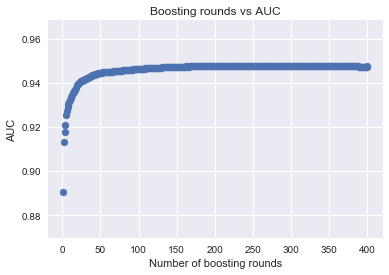

In [54]:
plt.scatter(results['round'], results['test-auc-mean'])
plt.xlabel('Number of boosting rounds')
plt.ylabel('AUC')
plt.title('Boosting rounds vs AUC')

We will now look at how the size of the training dataset affects the accuracy of our model.  As the amount of data fed to the model increases, so too does the model accuracy, However, once again there are diminishing returns.

In [34]:
# Let's look at how the size of the training data affects the AUC
data_sizes =  (0.995, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)
llst = []

def training_size():
    for sample in data_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample)
        bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
        cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, nfold=5, num_boost_round=400, as_pandas=True, metrics='auc')
        llst.append({'Size': ((1-sample)*len(X)), 'AUC': cv_results["test-auc-mean"][399]})
    return llst

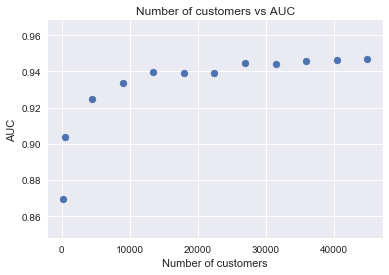

In [35]:
scores = pd.DataFrame(training_size())
plt.scatter(scores.Size, scores.AUC)
plt.xlabel('Number of customers')
plt.ylabel('AUC')
plt.title('Number of customers vs AUC')

We now create a graph to show feature importance. From it we can see that duration is the most important feature for predicting outcome. 

It can also be seen that some of the variable created in the feature engineering section are quite predictive. 2 out of the top 5 variables were created by us, and the date is the most important out of the two. This interestingly shows that there is more to marketing than targeting the right customer. Instead, it is the combination of contacting the right customer at the right time. Although this may seem obvious to many, the feature importance graph quantifies just exactly how important it is. 

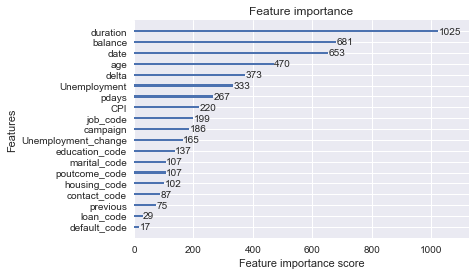

In [36]:
model = xgb.train(params=params, dtrain=bank_dmatrix, num_boost_round=210)
xgb.plot_importance(model, xlabel='Feature importance score',)
plt.show()

## Predictive Evaluation

In the previous section, we were able to create a model which had an excellent AUC score at 0.946354. It was approximately 0.8% better than the 0.938 obtained by previous researchers. However, it must be noted that one of the features which both I and the original researchers use in our models has no predictive power, and that is the duration variable. The reason it has no predictive power is because the duration of the final call can not be known until after the final call has been made. Two of the original researchers addressed it when they wrote their follow up paper in 2014. In the paper, they created a Neural Network, and without the duration variable they were able get an AUC score on 0.80. We will now drop the duration variable and re-evaluate our AUC.

The 2014 follow up paper can be found at:

http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf

In [59]:
#X_train = X_train.drop(['duration'],axis=1)
X_test = X_test.drop(['duration'],axis=1)

In [56]:
bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [57]:
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, num_boost_round=200, as_pandas=True, metrics='auc', nfold=15, early_stopping_rounds=50, seed=27)
print(cv_results[-1:])

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
199       0.817163      0.013507        0.878849       0.001237


To further evaluate the model which I have created, I will fit the model to the testing data and predict the probability of each customer in the training set signing up for a term deposit. The results of the predictions will measured by comparing how much revenue would be generated by calling a given percentage of the training set (ranked by the predicted probability of them opening an account).

In [69]:
# We fit the model to our origional training set
tic()
xg_cl = xgb.XGBClassifier(objective="reg:logistic", n_estimators=200, learning_rate=0.078, subsample=0.91, colsample_bytree=0.95, max_depth=5, seed=27)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict_proba(X_test)
toc()

Elapsed time is 3.178276777267456 seconds.


In [70]:
preds = pd.DataFrame(preds)
y_test = pd.DataFrame(y_test)
preds['number'] = range(1, len(preds) + 1)
y_test['number'] = range(1, len(y_test) + 1)
result = pd.merge(preds, y_test, on="number")

In [71]:
result = result.sort_values(by=[1], ascending=False)
result['number'] = range(1, len(y_test) + 1)

In [72]:
total_yes = result['y_code'].sum()
recall = []
calls = []

for x in range(len(result)):
    rec = result['y_code'][:x].sum()/total_yes
    called = x/len(result)
    recall.append(rec)
    calls.append(called)
    
result['recall'] = recall
result['called'] = calls
result.to_csv("results.csv")

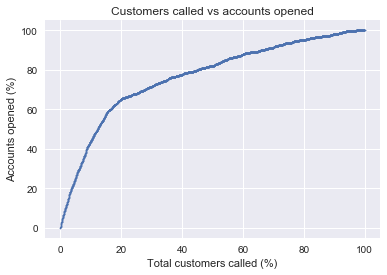

In [73]:
plt.scatter(result['called']*100, result['recall']*100, s=1)
plt.xlabel('Total customers called (%)')
plt.ylabel('Accounts opened (%)')
plt.title('Customers called vs accounts opened')
plt.figsize=(15,15)

From the Customers called vs revenue graph, it can be seen that if the customers in the training set were to be ranked according to how likely they are predicted to open a term deposit, there would be a trade-off between the amount of people we call and the percentage of the total term deposit accounts which could have been opened. For example, by calling only 20% of the customers in the training set, we would get approximately 65% of the total account openings (had we contacted all the customers). 

We can see that the model does a good job of predicting the probability that a customer will open an account, however the difficulty of this problem is that if we wish to capture all of the potential customers who would have opened an account, we need to contact almost all of the customers on our list. For example, if the bottom half of our ranked customers only have a 2% probability of opening an account, by not calling them we would have missed out on 90 term deposits being opened (note that we have 8986 customers in our training set). Thus we can see that there is a tradeoff between between calling every customer and capturing every possible sale, and calling only those customers who you predict have a high likelihood of opening a term deposit. The former would lead to the maximum possible revenue, the latter would lead to a much higher ROI. 

It is for this reason that we modeled this data set as a predictive problem as opposed to a classification problem. Since classification would require a threshold above which we call the customers to be set, in essence we are forced to make a choice between maximising revenue and maximising ROI, I feel that deciding which threshold value to use is a management question rather than a data science question.

## Insights and conclusion

From the results of our model evaluation, we can see just how powerful gradient boosted trees are. Not only are they very easy to build and tune, but they have excellent performance even when compared to more complex models such as neural networks. Their simplicity and ease of training means that they can be built and retrained as and when new data is available, opening up the possibility of continuously retraining our model during a marketing campaign to continuously improve its performance. We showed in the model creation section how quickly the model’s accuracy improves as we feed it more data.

In our evaluation section, we were able to visualise the trade-off between campaign size and revenue. By using our model, we are able to rank customers in order of how likely they are to open an account, and thus predict the campaign’s ROI and overall return. This empowers managers as it allows them to run campaigns inline with their budgetary constraints.

We also saw how important it was to optimise the timing of our calls. Although this isn't an area which we explored in great detail, we saw how the addition of date and economic features during our feature engineering allowed us to build a model whose accuracy exceeded models previously made by researchers. This is definitely an area which warrants further research, as there is no doubt that there are other variables which could further improve the accuracy of or model, thus allowing for more efficient marketing campaigns.

We saw the importance of the duration variable in our model. Personally I feel that this feature shows the importance of the relationship between the marketer and the customer. Although we wouldn’t be able to use the duration variable in a production model (since we won’t know the length of the final call until after the final call). We need to further explore the relationship between individual marketers and the customers they call. I feel that this is an area which would warrant further research. 